## Problema 5 - La distribución normal no se ajusta a todos los datos

#### Marc Nebot Moyano

##### Librerías necesarias

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
import sys
from sklearn.datasets import fetch_california_housing
from scipy.optimize import minimize
from scipy.stats import norm
from matplotlib.pyplot import title

#### a) Define la función de distribución de probabilidad como una función Python y representa la distribución para diferentes parámetros.

##### Función de distribución de probabilidad de Gumbel

In [146]:
def p(x,u,b):
    return 1/b * np.exp(-(x-u)/b) * np.exp(-np.exp(-(x-u)/b))

##### Función que devuelve todas las probabilidades dada una X

In [147]:
def pV(X,u,b):
    probabilidades = []
    for x in X:
        gumbel = p(x,u,b)
        """Si no hiciéramos este if, python redondea a 0 las probabilidades diminutas entonces
         para que no sea 0 y no tengamos que trabajar con infinitos al hacer log(0) 
         lo redondeamos al más pequeño posible y evitamos warnings"""
        if gumbel < 1/(10**323):                
            gumbel = 1/(10**323)
        probabilidades.append(gumbel)
    return probabilidades

Vamos a coger muestras de X para poder representar la distribución de Gumbel en función de distintas betas y mu

In [148]:
X = np.linspace(-8,6,1000)

##### Distribución con mu=0 y b=1

<function matplotlib.pyplot.show(close=None, block=None)>

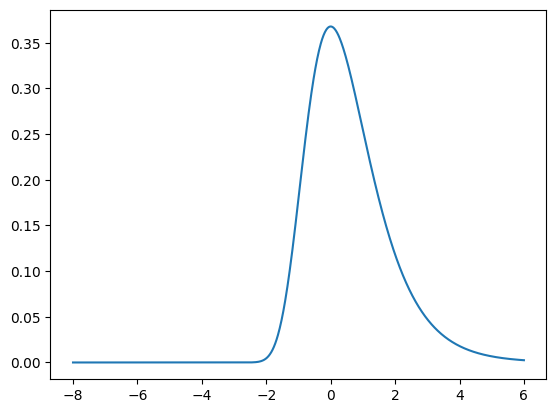

In [149]:
plt.plot(X, pV(X,0,1))
plt.show

##### Distribución con mu=1 y b=2

<function matplotlib.pyplot.show(close=None, block=None)>

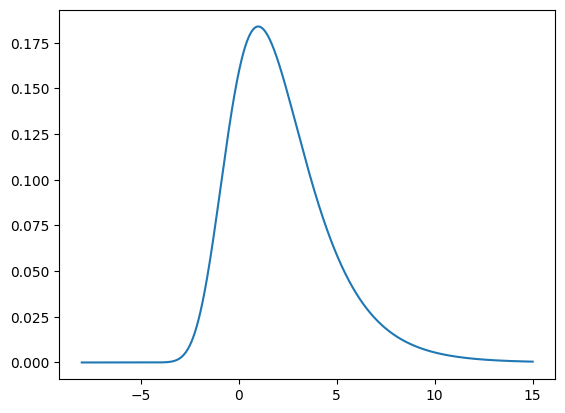

In [150]:
X = np.linspace(-8,15,1000)

plt.plot(X, pV(X,1,2))
plt.show

##### Distribución con mu=2 y b=3

<function matplotlib.pyplot.show(close=None, block=None)>

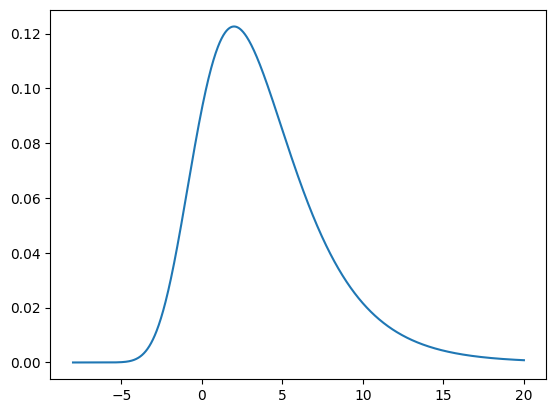

In [151]:
X = np.linspace(-8,20,1000)
    
plt.plot(X, pV(X,2,3))
plt.show

Hemos podido observar que Gumbel tiene una distribución irregular que no está centrada en el 0 a diferencia de la distribución normal

#### b) Escribe el logaritmo de la verosimilitud negativa de una muestra y encuentra las derivadas parciales con respecto a los parámetros.


##### Función que devuelve el logaritmo de la verosimilitud negativa de una muestra

In [152]:
def logVerosimilitudNegativa(params, X):
    u,b = params
    res = pV(X,u,b)
    return -np.log(res).sum()

Aquí podemos observar cuánto nos da la logVerosimilitud negativa, cosa que en próximos apartados usaremos para encontrar la mínima logverosimilitud negativa y estimar beta y mu

In [153]:
X = np.linspace(-8,20,1000)
print(logVerosimilitudNegativa([0,1],X))

70112.17647724012


##### Derivadas parciales respecto a los parámetros

Las derivadas parciales respecto a los parámetros beta y mu que nos quedarían son estas dándonos un sistema de ecuaciones no lineales que deberán resolverse numéricamente

<img src="DerivadasParcialesGumbel.png">

#### c) Las derivadas parciales dan como resultado un sistema de ecuaciones no lineales que deben resolverse numéricamente. Por el mismo precio podemos ajustar directamente los parámetros de la distribución mediante optimización numérica. Vamos a usar la función que proporciona la biblioteca scipy para la minimización de funciones no lineales (scipy.optimize.minimize) que optimiza una función que recibe un vector de parámetros, en este caso queremos minimizar el negativo del logaritmo de la probabilidad que será una función de los dos parámetros (u , B). El método de optimización que se debe usar es Nelder-Mead2. Tendrás que definir una función de python para el negativo del logaritmo de la probabilidad que recibirá un vector con los parámetros y la muestra de datos. Aplicaremos esta distribución al conjunto de datos California Housing que se puede descargar usando la función fetch_california_housing de la biblioteca scikit-learn. Si representas las variables, verás que hay varias variables que se comportan como la distribución de Gumbel. Elige dos de estas variables y utiliza la función de minimización para ajustar la verosimilitud logarítmica negativa de la distribución de Gumbel a los datos de estas variables.

##### Análisis del dataset

Primeramente vamos a observar el dataset para ver qué variables tiene y luego poderlas comparar

In [154]:
california_housing = fetch_california_housing(as_frame=True)
california_housing.frame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


Seguidamente vamos a representar las variables usando histogramas para ver cuáles siguen la distribución de Gumbel estudiada anteriormente

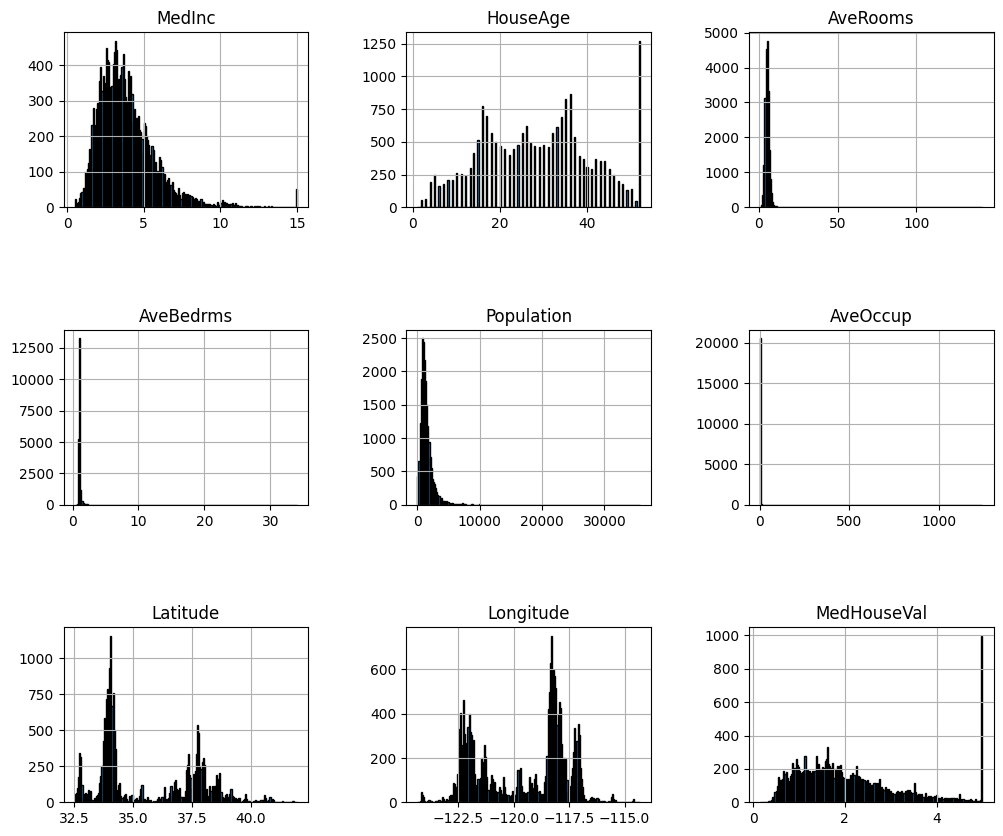

In [155]:
california_housing.frame.hist(figsize=(12, 10), bins=200, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

Después de observarlas, hemos decidido usar la variable MedInc y la variable MedHouseVal para realizar nuestros experimentos, ambas tienen forma de distribución de Gumbel exceptuando por una irregularidad a la derecha de las gráficas

##### Minimización del negativo del logaritmo de probabilidad de MedInc

In [156]:
first_guess = [0, 1]
XMedInc = california_housing.frame['MedInc'].values
res = minimize(logVerosimilitudNegativa, x0 = first_guess, args = XMedInc, options={'xtol': 1e-8, 'disp': True})
muMedInc = res.x[0]
betaMedInc = res.x[1]
print("mu = ", muMedInc)
print("beta = ", betaMedInc)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11636\4290423318.py:3: OptimizeWarning: Unknown solver options: xtol
  res = minimize(logVerosimilitudNegativa, x0 = first_guess, args = XMedInc, options={'xtol': 1e-8, 'disp': True})


         Current function value: 39464.325511
         Iterations: 13
         Function evaluations: 66
         Gradient evaluations: 22
mu =  3.0532387309551146
beta =  1.3718833369457044


Podemos observar que nuestra minimización ha resultado con éxito obtenido los valores de mu =  3.0532387309551146 y de beta =  1.3718833369457044

##### Minimización del negativo del logaritmo de probabilidad de MedHouseVal

In [157]:
first_guess = [0, 1]
XMedHouse = california_housing.frame['MedHouseVal'].values
res = minimize(logVerosimilitudNegativa, x0 = first_guess, args = XMedHouse, options={'xtol': 1e-8, 'disp': True})
muMedH = res.x[0]
betaMedH = res.x[1]
print("mu = ", muMedH)
print("beta = ", betaMedH)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11636\333891580.py:3: OptimizeWarning: Unknown solver options: xtol
  res = minimize(logVerosimilitudNegativa, x0 = first_guess, args = XMedHouse, options={'xtol': 1e-8, 'disp': True})


         Current function value: 29847.617110
         Iterations: 12
         Function evaluations: 48
         Gradient evaluations: 16
mu =  1.5515223020374411
beta =  0.8507526272510811


Podemos observar que nuestra minimización ha resultado con éxito obtenido los valores de mu =  1.5515223020374411 y de beta =  0.8507526272510811

#### d) Representa la distribución de Gumbel para los parámetros ajustados contra el histograma normalizado de los datos. ¿Los parámetros se ajustan bien a los datos?

##### Representación del histograma normalizado y la distribución de Gumbel con los parámetros ajustados de MedInc

Seguidamente vamos comprobar si se ajustan bien a los datos los valores obtenidos en el anterior apartado. Podemos observar que en el caso de MedInc sí se ajustan perfectamente a los datos como muestran nuestras gráficas adyacentes

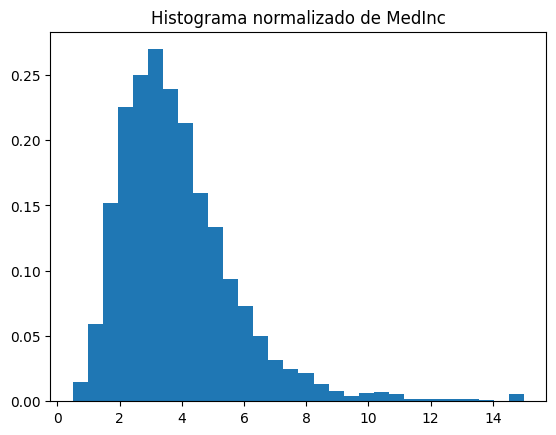

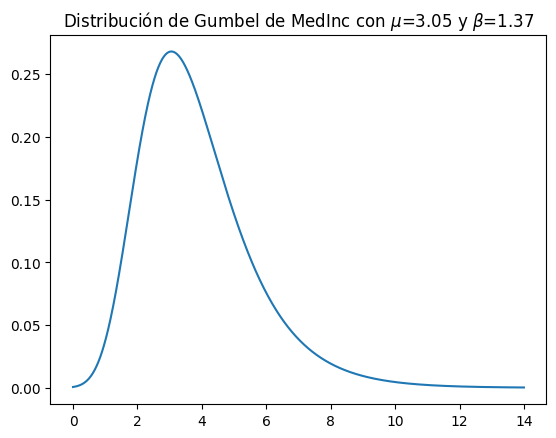

In [158]:
plt.hist(x=XMedInc, bins=30, density=True)
plt.title("Histograma normalizado de MedInc")
plt.show()

X = np.linspace(0,14,1000)
plt.plot(X, pV(X, muMedInc, betaMedInc))
plt.title("Distribución de Gumbel de MedInc con" r" $\mu$=3.05 y $\beta$=1.37")
plt.show()

##### Representación del histograma normalizado y la distribución de Gumbel con los parámetros ajustados de MedHouseVal

Seguidamente observaremos si se ajustan también em MedHouseVal. Podemos ver que sí se ajustan pero tenemos esa pequeña irregularidad en x=5 donde no se
acaba de ajustar aunque podemos ignorarla, esto es debido a la irregularidad de la muestra, probablemente en otra variable que siga una distribución de Gumbel sin irregularidades se hubiera ajustado mejor

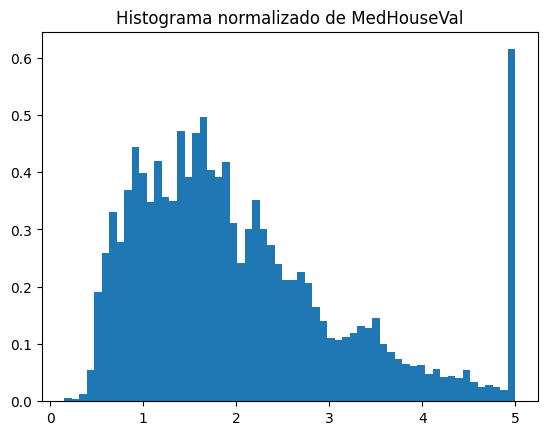

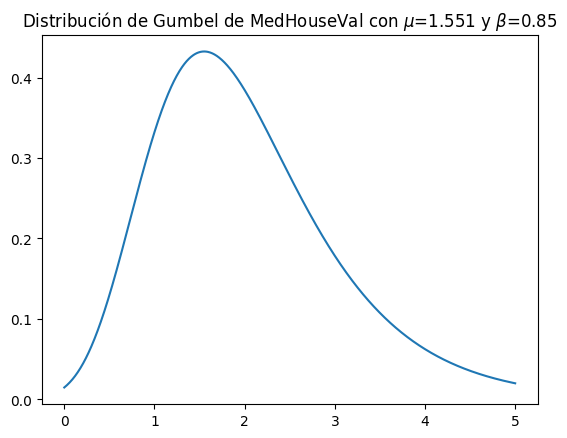

In [159]:
plt.hist(x=XMedHouse, bins=60, density=True)
plt.title("Histograma normalizado de MedHouseVal")
plt.show()

X = np.linspace(0,5,1000)
plt.plot(X, pV(X, muMedH, betaMedH))
plt.title("Distribución de Gumbel de MedHouseVal con" r" $\mu$=1.551 y $\beta$=0.85")
plt.show()

##### e) Ahora calcula la media y la varianza de las variables asumiendo que son gausianas y calcula el logaritmo de la probabilidad que las distribuciones gausiana y Gumbel asignan a una muestra de los datos (puedes usar la función scipy.stats.norm.pdf para la gausiana). ¿Hay una gran diferencia en las probabilidades?

##### Función que calcula la log verosimilitud

In [160]:
def logProb(probs):
    return np.log(probs).sum()

##### Cálculo de la media y varianza de MedInc y MedHouseVal

In [161]:
mediaInc = california_housing.frame["MedInc"].mean()
varianzaInc = california_housing.frame["MedInc"].std()**2

mediaHouseVal = california_housing.frame["MedHouseVal"].mean()
varianzaHouseVal = california_housing.frame["MedHouseVal"].std()**2

print("La media de MedInc es ", mediaInc, " y su varianza es de ", varianzaInc, ".")
print("La media de MedHouseVal es ", mediaHouseVal, " y su varianza es de ", varianzaHouseVal, ".")


La media de MedInc es  3.8706710029069766  y su varianza es de  3.6093225599765124 .
La media de MedHouseVal es  2.068558169089147  y su varianza es de  1.3316148163035277 .


##### Diferencias entre Gauss y Gumbel

Podemos observar que hay bastante diferencia entre ambas probabilidades y esto es debido a que las funciones son realmente distintas ya que una se centra en el 0 y Gumbel es bastante irregular por lo tanto la diferencia de parámetros es notable

In [162]:
probabilidadesGauss = norm.pdf(XMedInc)
probabilidadesGumbel = pV(XMedInc, muMedInc, betaMedInc)

logProbsGauss = logProb(probabilidadesGauss)
logProbGumbel = logProb(probabilidadesGumbel)

print(logProbsGauss - logProbGumbel)

-171364.1801834751


In [163]:
probabilidadesGauss = norm.pdf(XMedHouse)
probabilidadesGumbel = pV(XMedHouse, muMedH, betaMedH)

logProbsGauss = logProb(probabilidadesGauss)
logProbGumbel = logProb(probabilidadesGumbel)

print(logProbsGauss - logProbGumbel)

-47019.46082905638
